# HM04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.cluster import KMeans
import sklearn

from sklearn.preprocessing import StandardScaler

In [2]:
#Load the data
data = pd.read_csv("CrowdstormingDataJuly1st.csv")

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
list(data.columns.values)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

## 0. Data Cleaning

### 0.1 NaN Values

In [5]:
def columns_nanValues(data):
    # print all columns with at least one NaN value
    l = list()
    for c in data:
        if data[c].hasnans:
            l.append(c)
    return l

columns_nanValues(data)

['height',
 'weight',
 'position',
 'photoID',
 'rater1',
 'rater2',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

**Remove entries with no Skin Color feature**

Some columns contains NaN values. For this homework, we will not be able to work with data having no *skin color* feature. Therefore we only keep instances with this information.

In [6]:
# We remove all instance with no 'photoID' information, since the skin color needs this information
data_clean = data[~data.photoID.isnull()]
nan_col = columns_nanValues(data_clean)
nan_col

['height',
 'weight',
 'position',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

In [7]:
data_clean[nan_col].dtypes

height      float64
weight      float64
position     object
Alpha_3      object
meanIAT     float64
nIAT        float64
seIAT       float64
meanExp     float64
nExp        float64
seExp       float64
dtype: object

**Percentage of NaN cells per column**

In [8]:
for x in nan_col:
    nbr = data_clean[x].isnull().sum()
    print(x, '-->', nbr)
    print("   Total percentage: ", nbr/len(data_clean)*100)

height --> 46
   Total percentage:  0.0369119169321
weight --> 753
   Total percentage:  0.60423203152
position --> 8461
   Total percentage:  6.78938541658
Alpha_3 --> 1
   Total percentage:  0.000802432976786
meanIAT --> 153
   Total percentage:  0.122772245448
nIAT --> 153
   Total percentage:  0.122772245448
seIAT --> 153
   Total percentage:  0.122772245448
meanExp --> 153
   Total percentage:  0.122772245448
nExp --> 153
   Total percentage:  0.122772245448
seExp --> 153
   Total percentage:  0.122772245448


For the values related to the *IAT* and *Exp*, we decided to remove those rows, since the fraction of "corrupt" rows is almost insignificant.

In [9]:
data_clean = data_clean[~data_clean.nIAT.isnull()]
# Colums still have NaN values
nan_col = columns_nanValues(data_clean)
nan_col

['height', 'weight', 'position']

### 0.2 Dealing with missing data

**Potential fixes to missing cells**

We know that there are multiple entries per player in our dataset. Therefore, is it possible that the information about *weight*, *height*, or *position* for a player is missing in one entry but present in another ? If yes, we could simply replace the missing values by the ones present in another row, but as we can see, such case doesn't occur.

In [10]:
# Assert if any missing values for a player feature
# are not present in another row

for col in nan_col:
    data_noWeight = data_clean[data_clean[col].isnull()]
    data_withWeight = data_clean[~data_clean[col].isnull()]

    i1 = list(data_noWeight.index)
    i2 = list(data_withWeight.index)

    nbr = [x for x in i1 if x in i2]
    print(col, '-->', nbr)

height --> []
weight --> []
position --> []


**Drop rows or fill mean values to the cell**

Now we are sure that there is no way to recover this values. We have therefore two possibilities:
- Replace the missing *height* and *weight* values by the mean of all players
- Remove the rows with missing values

We've decided to go for the second option, as the percentage of data concern is low (then that 1%)

In [11]:
nan_values_to_drop = ['weight', 'height']
for col in nan_values_to_drop:
    data_clean = data_clean[~data_clean[col].isnull()]

In [12]:
# Last feature to clean
columns_nanValues(data_clean)

['position']

There is still one remaining feature for which we need to clean. For the *position* column, we can:

- Replace all missing entries by a *dummy* variable, like "Unknown"
- Replace all missing entries by the most frequent one according to the rest entries (*position* is not numerical, therefore no mean)
- Remove the rows with missing values

We decide to remove those rows. But before doing so, we want to assert that we aren't throwing valuable information. We compare the skin color rated by *rater1* and *rater2* column with NaN value against the data witouh NaN values.

In [13]:
# Data WITH NaNs values
nan_data = data_clean[data_clean.position.isnull()]
print(nan_data.rater1.describe())
print('----')
print(nan_data.rater2.describe())

count    8258.000000
mean        0.287600
std         0.297938
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater1, dtype: float64
----
count    8258.000000
mean        0.324837
std         0.313449
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater2, dtype: float64


In [14]:
# Data WITHOUT NaNs values
good_data = data_clean[~data_clean.position.isnull()]
print(good_data.rater1.describe())
print('----')
print(good_data.rater2.describe())

count    115457.000000
mean          0.261946
std           0.294666
min           0.000000
25%           0.000000
50%           0.250000
75%           0.250000
max           1.000000
Name: rater1, dtype: float64
----
count    115457.000000
mean          0.300796
std           0.291061
min           0.000000
25%           0.000000
50%           0.250000
75%           0.500000
max           1.000000
Name: rater2, dtype: float64


**Remove rows with empty position information based on observation of skin color rating comparison**

As we cann see, there is no major difference between the two portions of data. Therefore, we have decided to remove these rows.


| rater1| NaN | No NaN |
|------|--------|--------|
| mean |    0.287600    |    0.261946    |
| std  |     0.297938   |  0.294666      |


| rater2| NaN | No NaN |
|------|--------|--------|
| mean |    0.324837    |    0.300796    |
| std  |     0.313449   |  0.291061      |

In [15]:
# Remove all entries with NaNs values in the 'position' column
data_clean = data_clean[~data_clean.position.isnull()]

In [16]:
# Assert no more "NaN" values in our dataframe
columns_nanValues(data_clean)

[]

### 0.3 Tuning the SkinColor feature

The *skin color* feature is stored in two columns: *rater1* and *rater2*. Based on these two columns, we create a new feature *skinColor* by aggregating the two results. But before, let's take a look on the raters results.

In [17]:
data_skin = data_clean
data_skin["skinColorDiff"] = (data_skin.rater1-data_skin.rater2).abs()

It's obvious that the two raters aren't always on the same page, therefore it is natural to have different results for the same player.

In [18]:
# Search if there are entries where rater rating differ more than 0.25
data_colorDiff = data_skin[data_skin.skinColorDiff > 0.25]
len(data_colorDiff)

164

For 164 entries, the two raters have major split opinions.

In [19]:
print(data_colorDiff.rater1.unique())
print(data_colorDiff.rater2.unique())

[ 0.]
[ 0.5]


**Keep entries with consistent skin ratings**

**Reason:** When one rater consider the player's skin as *very light skin* and the other as *neither dark not light skin*. The number of these entries are small comparing to the entire dataset and any attemp to make a compromise of the two and leaving these entries in might raise the bias of the outcome of our classifier, we've decided that those entries aren't reliable and therefore remove it.

In [20]:
## Display the total number of entries
data_skin_clean = data_skin[data_skin.skinColorDiff <= 0.25]
len(data_skin_clean)

115293

**Merge two columns in one**

Now we can create the *skinColor* feature by aggregating the two raters results.

In [21]:
# Add the skin color based on the two raters
data_skin_clean["skinColor"] = (data_skin.rater1+data_skin.rater2)/2

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### 0.4 Remove referees

Now we need to look a little more into the referees features. As mentionned in the [complementary reading](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) for this assignement, there are some referees in this dataset who have less than 22 dyads. Since we want to take into consideration only games in the four leagues (England, France, Germany, and Spain), we need to remove all dyads where a referee has less that 1 game. Note that these doesn't mean we remove all possible ref-related noise of our data.

In [22]:
# Group the data by refs
data_by_refs = data_skin_clean.groupby('refNum').size()
refsToKeep = data_by_refs >= 22

# Retrieve the 'refNum' of refs to keep in the data
refsToKeepID = list()
for i,x in enumerate(refsToKeep):
    if x:
        refsToKeepID.append(refsToKeep.index[i])

# Keep only the refs with at least 22 games
data_clean = data_skin_clean[data_skin_clean.refNum.isin(refsToKeepID)]

In [23]:
data = data_clean
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColorDiff,skinColor
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.000


Now, we consider that our dataset is clean and we can go for the first part of the assignment!

> Note about the data. We found something disturbing. The player *Aaron Hughes* has played, according to wikipedia, 

## 1.
>Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?

### 1.1 Cross-Featuring
For this first part, we only care about player description. Therefore, we need to keep only one entry per player and for each player to aggregate his data with all refs with who he has a dyad.

In [24]:
data_by_player = data.groupby('playerShort')
data_player = data_by_player.agg({
        # Keep only one entry per player
        'player'    : 'first',
        'club'      : 'first',
        'leagueCountry' : 'first',
        'birthday'  : 'first',
        'position'  : 'first',
        'height'    : 'mean',
        'weight'    : 'mean',
        'skinColor' : 'mean',
        
        # Sum all referees data
        'games'     : 'sum',
        'victories' : 'sum',
        'ties'      : 'sum',
        'defeats'   : 'sum',
        'goals'     : 'sum',
        'yellowCards' : 'sum',
        'yellowReds': 'sum',
        'redCards'  : 'sum',
        
        'meanIAT'   : 'mean',
        'meanExp'   : 'mean',
        'seIAT'     : 'mean',
        'seExp'     : 'mean'
    })

data_player.head()

,games,position,goals,seIAT,defeats,ties,seExp,meanExp,weight,redCards,club,meanIAT,player,birthday,height,victories,leagueCountry,skinColor,yellowCards,yellowReds
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,635,Center Back,8,0.000282,221,174,0.001321,0.484931,71.0,0,Fulham FC,0.345065,Aaron Hughes,08.11.1979,182.0,240,England,0.125,19,0
aaron-hunt,328,Attacking Midfielder,59,0.000227,119,70,0.001032,0.451448,73.0,1,Werder Bremen,0.349424,Aaron Hunt,04.09.1986,183.0,139,Germany,0.125,39,0
aaron-lennon,411,Right Midfielder,31,0.000371,115,96,0.002052,0.492832,63.0,0,Tottenham Hotspur,0.346085,Aaron Lennon,16.04.1987,165.0,200,England,0.250,11,0
aaron-ramsey,253,Center Midfielder,39,0.000496,67,42,0.002826,0.511374,76.0,1,Arsenal FC,0.347013,Aaron Ramsey,26.12.1990,178.0,144,England,0.000,31,0
abdelhamid-el-kaoutari,124,Center Back,1,0.001488,43,40,0.005296,0.335587,73.0,2,Montpellier HSC,0.331600,Abdelhamid El-Kaoutari,17.03.1990,180.0,41,France,0.250,8,4


In [25]:
data_player.sort(columns="games", ascending=False)["games"]

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


playerShort
frank-lampard             890
xavi                      789
iker-casillas             773
steven-gerrard            763
jamie-carragher           745
john-arne-riise           703
rio-ferdinand             700
john-terry                695
mark-schwarzer            677
paul-scholes              674
xabi-alonso               665
gareth-barry              665
phil-neville              661
ashley-cole               660
petr-cech                 655
mickael-landreau          654
shay-given                646
cristiano-ronaldo         645
pepe-reina                639
puyol                     638
aaron-hughes              635
william-gallas            612
wayne-rooney              607
michael-carrick           602
bastian-schweinsteiger    601
philipp-lahm              600
florent-malouda           594
fernando-torres           593
claudio-pizarro           589
john-oshea                584
                         ... 
anderson-conceicao         23
pape-mbow                  2

#### 1.1.1 IAT and Exp
There is still some columns that we can aggregate from the original dataset. We decided to combine the *meanIAT* and *meanExp* together, and the *seIAT* with the *seExp*.

In [26]:
# Before aggregations the IAT and Exp data together, we decided to change the data
# in order to have values between [0,1]

def column_maxmin(column):
    """
        Normalize the column values in a given dataframe
    """
    maxmin = column.max() - column.min()
    return (column - column.min()) / maxmin


data_player.meanIAT = column_maxmin(data_player.meanIAT)
data_player.seIAT   = column_maxmin(data_player.seIAT)
data_player.meanExp = column_maxmin(data_player.meanExp)
data_player.seExp   = column_maxmin(data_player.seExp)

Now we can aggregate the columns.
- $meanIATEXP = \frac{meanIAT + meanExp}{2}$
- $seIATEXP = \sqrt{seIAT² + seExp^2}$

In [27]:
data_player["meanIATEXP"] = (data_player.meanIAT + data_player.meanExp) / 2
data_player["seIATEXP"] = (data_player.seIAT**2 + data_player.seExp**2)**0.5
data_player.head()

,games,position,goals,seIAT,defeats,ties,seExp,meanExp,weight,redCards,...,player,birthday,height,victories,leagueCountry,skinColor,yellowCards,yellowReds,meanIATEXP,seIATEXP
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,635,Center Back,8,0.030137,221,174,0.028156,0.434369,71.0,0,...,Aaron Hughes,08.11.1979,182.0,240,England,0.125,19,0,0.481152,0.041243
aaron-hunt,328,Attacking Midfielder,59,0.024027,119,70,0.021812,0.399713,73.0,1,...,Aaron Hunt,04.09.1986,183.0,139,Germany,0.125,39,0,0.483823,0.032451
aaron-lennon,411,Right Midfielder,31,0.039880,115,96,0.044180,0.442548,63.0,0,...,Aaron Lennon,16.04.1987,165.0,200,England,0.250,11,0,0.489919,0.059518
aaron-ramsey,253,Center Midfielder,39,0.053753,67,42,0.061155,0.461739,76.0,1,...,Aaron Ramsey,26.12.1990,178.0,144,England,0.000,31,0,0.503773,0.081421
abdelhamid-el-kaoutari,124,Center Back,1,0.163288,43,40,0.115304,0.279791,73.0,2,...,Abdelhamid El-Kaoutari,17.03.1990,180.0,41,France,0.250,8,4,0.342083,0.199895


#### 1.1.2  Cards
Players can receive a yellow card, a red card resulting of two yellows one, or a direct red card. 

We've decided to combine these cards features:
- *cardsPerGame*: Sum of all cards divided by the number of games
- *yellowCardNorm*: The number of yellow cards for a player divided by the total number of yellow cards (for all players). Between [0,1]
- *yellowRedsNorm*: Same as *yellowCardStand*, but with the yellowReds
- *redCardsNorm*: Same as *yellowCardStand*, but with the redCards

In [28]:
# cardsPerGame
data_player['cardsPerGame'] = (data_player.yellowCards + data_player.yellowReds + data_player.redCards)\
                                / data_player.games

In [29]:
#yellowCardNorm
data_player['yellowCardNorm'] = data_player.yellowCards / data_player.yellowCards.sum()
data_player['yellowCardNorm'] = column_maxmin(data_player['yellowCardNorm'])

In [30]:
#yellowRedsNorm
data_player['yellowRedsNorm'] = data_player.yellowReds / data_player.yellowReds.sum()
data_player['yellowRedsNorm'] = column_maxmin(data_player['yellowRedsNorm'])

In [31]:
#redCardsNorm
data_player['redCardsNorm'] = data_player.redCards / data_player.redCards.sum()
data_player['redCardsNorm'] = column_maxmin(data_player['redCardsNorm'])

In [32]:
data_player.head()

,games,position,goals,seIAT,defeats,ties,seExp,meanExp,weight,redCards,...,leagueCountry,skinColor,yellowCards,yellowReds,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,635,Center Back,8,0.030137,221,174,0.028156,0.434369,71.0,0,...,England,0.125,19,0,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000
aaron-hunt,328,Attacking Midfielder,59,0.024027,119,70,0.021812,0.399713,73.0,1,...,Germany,0.125,39,0,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909
aaron-lennon,411,Right Midfielder,31,0.039880,115,96,0.044180,0.442548,63.0,0,...,England,0.250,11,0,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000
aaron-ramsey,253,Center Midfielder,39,0.053753,67,42,0.061155,0.461739,76.0,1,...,England,0.000,31,0,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909
abdelhamid-el-kaoutari,124,Center Back,1,0.163288,43,40,0.115304,0.279791,73.0,2,...,France,0.250,8,4,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818


#### 1.1.3 Cards & IATEXP

We want to create a feature by combing the cards and the IAT and Exp data. Therefore, we create a new feature:
- *cardsIATExp* = (yellowCardNorm + yellowRedsNorm + redCardsNorm) * meanIATEXP

In [33]:
data_player['cardsIATExp'] = (data_player.yellowCardNorm + data_player.yellowRedsNorm + data_player.redCardsNorm) \
                                * data_player.meanIATEXP
    
data_player.head()

,games,position,goals,seIAT,defeats,ties,seExp,meanExp,weight,redCards,...,skinColor,yellowCards,yellowReds,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,635,Center Back,8,0.030137,221,174,0.028156,0.434369,71.0,0,...,0.125,19,0,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000,0.048887
aaron-hunt,328,Attacking Midfielder,59,0.024027,119,70,0.021812,0.399713,73.0,1,...,0.125,39,0,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909,0.144888
aaron-lennon,411,Right Midfielder,31,0.039880,115,96,0.044180,0.442548,63.0,0,...,0.250,11,0,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000,0.028819
aaron-ramsey,253,Center Midfielder,39,0.053753,67,42,0.061155,0.461739,76.0,1,...,0.000,31,0,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909,0.129311
abdelhamid-el-kaoutari,124,Center Back,1,0.163288,43,40,0.115304,0.279791,73.0,2,...,0.250,8,4,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818,0.190859


### 1.2 Convert columns types

As seen previously, some of our columns have the *object* type. Since the library we are using doesn't deal with this type of column values, we need to change it by using a *LabelEncoder()*

In [34]:
def columnEncoder(df, col):
    """
    Replace all values of a column by applying the 'LabelEncoder' form 'sklearn'
    
    INPUT:
        df: The dataframe containing the columns to change
        col: The column name over which the 'LabelEncoder' will be applied
        
    OUTPUT:
        The dataframe with news values in the specified column
    """
    labelEncoder = preprocessing.LabelEncoder()
    df[col] = labelEncoder.fit_transform(df[col])

In [35]:
data_player.dtypes

games               int64
position           object
goals               int64
seIAT             float64
defeats             int64
ties                int64
seExp             float64
meanExp           float64
weight            float64
redCards            int64
club               object
meanIAT           float64
player             object
birthday           object
height            float64
victories           int64
leagueCountry      object
skinColor         float64
yellowCards         int64
yellowReds          int64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

In [36]:
# Convert all columns with type 'object'
col_object = data_player.dtypes == 'object'
for col in data_player.loc[:,col_object]:
    columnEncoder(data_player, col)

Now all the columns are numbers, but we have decided to work only *float64* values.

In [37]:
data_player = data_player.astype(float)
data_player.dtypes

games             float64
position          float64
goals             float64
seIAT             float64
defeats           float64
ties              float64
seExp             float64
meanExp           float64
weight            float64
redCards          float64
club              float64
meanIAT           float64
player            float64
birthday          float64
height            float64
victories         float64
leagueCountry     float64
skinColor         float64
yellowCards       float64
yellowReds        float64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

### 1.3 Prepare data for ML

In [38]:
X = data_player.drop('skinColor', axis=1)

The assignement asked us to use the *RandomForestClassifier*. Therefore, we need to work with discrete values. We've decided to add a new column to our data: *isBlack*. This column takes the value *True* if the *skinColor* average of the two raters is bigger than 0.5.

Note that if *isBlack* is false, it doesn't mean that the player has light skin (can be *neither dark nor light skin*).

In [39]:
data_player['isBlack'] = data_player["skinColor"] > 0.5
y = data_player['isBlack']

### 1.4 Random Forest Classifier - Assert model

As specified in the assignement, we use *cross-validation* with the *radom forest classifier* to perform our prediction, therefore mitigating the overfitting of the model.

We start by choosing the best parameters for our classifier. We've decided to tune two parameters of the scikit RandomForestClassifier:
- n_estimators
- max_features

#### 1.4.1 n_estimators

In [40]:
n_range = range(1,100)
scores = list()

max_scores = -1
best_n = -1

for i in n_range:
    ml = RandomForestClassifier(n_estimators=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
    if (i%10==0):
        print(i, cross.mean())
        
# Best values
print("Best",best_n, max_scores)

10 0.855921914466
20 0.848854688414
30 0.855911996804
40 0.85522282632
50 0.85591699131
60 0.85733043652
70 0.863693579919
80 0.859453172938
90 0.859453172938
Best 67 0.864397805271


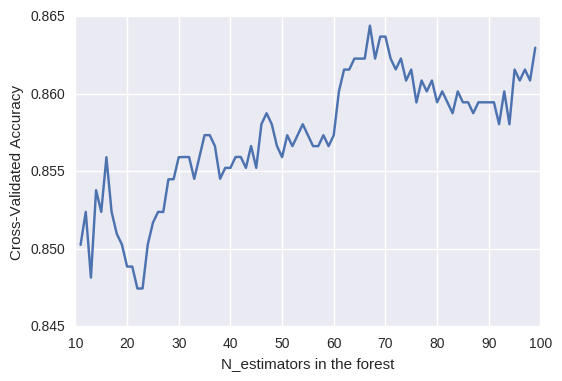

In [41]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_range[10:], scores[10:])
plt.xlabel('N_estimators in the forest')
plt.ylabel('Cross-Validated Accuracy')

#### 1.4.2 max_features

In [42]:
max_features = range(1,len(X.columns))
scores = list()

max_scores = -1
best_n = -1

for i in max_features:
    ml = RandomForestClassifier(max_features=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
# Best values
print(best_n, max_scores)

19 0.856651326398


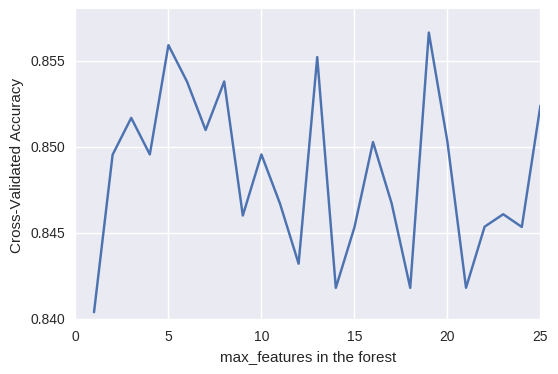

In [43]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_features, scores)
plt.xlabel('max_features in the forest')
plt.ylabel('Cross-Validated Accuracy')

- n_estimators = 67
- max_features = 19

#### 1.4.3 Model with ALL features

In [44]:
def RFCmodel_cv_featureImportance(X,y):
    """
        Compute the RandomForestClassifier for features dataframe X and classes features y.
        It prints the accuracy of the model using cross-validation, a graph displaying
        the importance for each features, and the confusion-matrix.
    """
    
    ml = RandomForestClassifier(n_estimators=67, max_features=19, random_state=1)

    # Cross-validation accuracy
    cross = (cross_val_score(ml, X, y, cv=10))
    print("Cross-validation:", cross.mean())

    # Feature importance
    ml.fit(X,y)
    feature_importance = ml.feature_importances_

    # Combining the features_importance array with the corresponding feature name
    l1 = list(zip(feature_importance, X.columns))
    l1.sort(key=lambda x: x[0], reverse=True)
    features = list(map(lambda x: x[0], l1))
    features_names = list(map(lambda x: x[1], l1))

    # Plot the features_importances graph
    graph = sns.barplot(features_names, features, palette='BuGn_r')
    graph.set_title("Features importance")
    graph.set_xticklabels(labels=features_names, rotation=90)
    plt.show()
    
    
    # Print confusion_matrix
    y_predicted = cross_val_predict(ml, X, y, cv=10)
    cm = metrics.confusion_matrix(y, y_predicted)
    print(cm)
    print("Confusion matrix")
    print("White as white: ", cm[0][0])
    print("White as black: ", cm[0][1])
    print("black as white: ", cm[1][0])
    print("black as black: ", cm[1][1])

**Features Importance**

The features importance graph show how much weight the classifier takes into account for the decision making, as we can observe here red/yellow card numbers has less influence in the outcome oppose to seIATEXP and seIAT seExp. It it also observable that according to the confusion matrix, the precise outcome of the prediction, the number of white/black player being classified correctly/wrongly.

Cross-validation: 0.856641266036


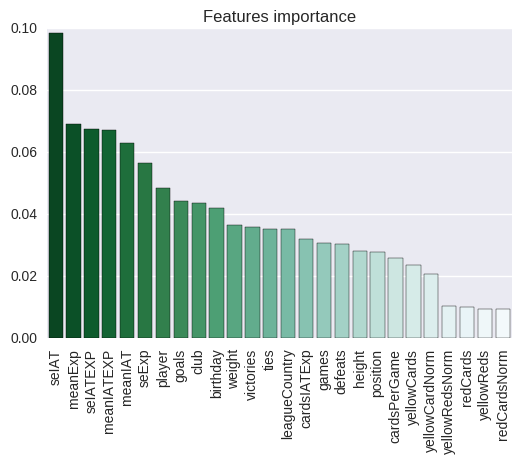

[[1158   31]
 [ 172   55]]
Confusion matrix
White as white:  1158
White as black:  31
black as white:  172
black as black:  55


In [45]:
RFCmodel_cv_featureImportance(X,y)

#### 1.4.4 Model with some selected features

Now we decided to run the model but with some arbitrarily-selected features.

In [46]:
features_to_keep = [
    "leagueCountry",
    "club",
    "weight",
    "height",
    "games",
    "position",
    "birthday",
    'meanIATEXP',
    'seIATEXP',
    'cardsPerGame',
    'yellowCardNorm',
    'yellowRedsNorm',
    'redCardsNorm',
    'cardsIATExp',
]

X = data_player[features_to_keep]

Cross-validation: 0.854518600968


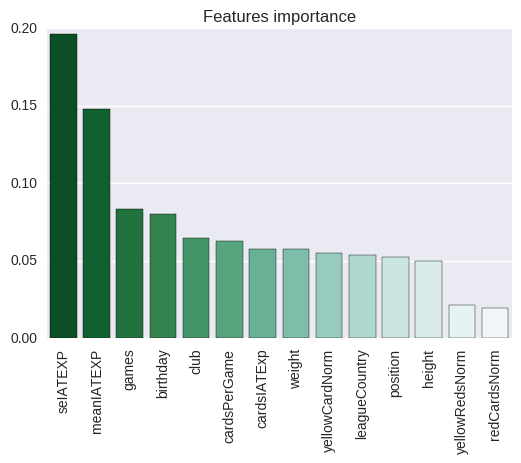

[[1148   41]
 [ 165   62]]
Confusion matrix
White as white:  1148
White as black:  41
black as white:  165
black as black:  62


In [47]:
RFCmodel_cv_featureImportance(X,y)

#### 1.4.5 Experiment in selected features

We try different feature selections to try to improve the accuracy as well as to observe the change of confusion matrix. At first from the full feature we try to drop a single feature to observe changes. Note: more important feature doest not necessarily mean that by dropping it the accuracy decrease nor increase by a vast amount. 
1. drop player name, 0.8608 accuracy
2. drop birthday, 0.8615
3. drop ties, 0.8622

Then we tried to drop tuples of feature which are closely related to each other like red/yellow card 

Cross-validation: 0.85663627153


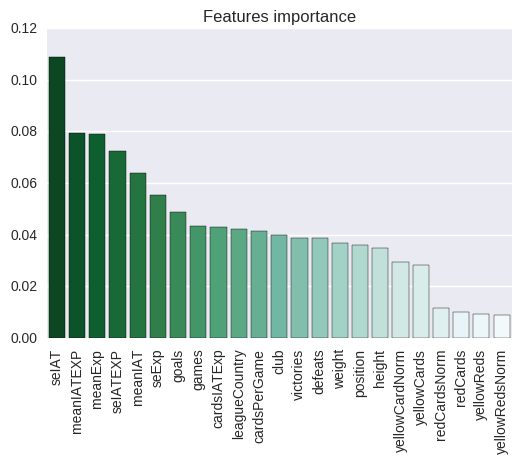

[[1148   41]
 [ 162   65]]
Confusion matrix
White as white:  1148
White as black:  41
black as white:  162
black as black:  65


In [48]:
features_experiment_1 = [
 'redCards',
 'victories',
 'height',
 'defeats',
 'seIAT',
 'weight',
 'meanExp',
 'seExp',
 'games',
 'club',
 'leagueCountry',
 #'birthday',
 'meanIAT',
 #'player',
 #'ties',
 'yellowReds',
 'goals',
 # 'skinColor',
 'position',
 'yellowCards',
 'meanIATEXP',
 'seIATEXP',
 'cardsPerGame',
 'yellowCardNorm',
 'yellowRedsNorm',
 'redCardsNorm',
 'cardsIATExp',
 # 'isBlack',
]

X = data_player[features_experiment_1]

RFCmodel_cv_featureImportance(X,y)

#### 1.4.6 Comments

From the confusion matrix, we can observed that our model preforms well on non-black players (noted as *white* in our confusion matrix textual representation).
Indeed, we have only 2.6% of white and neither white or black people missclassified.

The problem resides in black players. We have more than 7 players out of 10 who are missclassified! This enormous error doesn't how up on our cross-validation correctness (more than 86%).

Why ? As we can see, there is a lot more of non-black player on our data. Therefore, it is difficult for our machine learning algorithm to be trained for this class of the data. With only 16% of black players, we cannot ask miracles to our ML algo....

In [49]:
w = 41/(41+1148)*100
print("White people missclassified in percent:", w)

b = 162/(162+65)*100
print("Black people missclassified in percent:", b)

b_on_w = (162+65) / ( (162+65) + (41+1148) ) * 100
print("Percentage of black players in the entire dataset:", b_on_w)

White people missclassified in percent: 2.607232968881413
Black people missclassified in percent: 72.24669603524228
Percentage of black players in the entire dataset: 16.031073446327685


# 2.

>Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

###  Unsupervised learning

We have (arbitrarly) decided to work with the *k_means* algorithm from scikit.

**Demonstration of the method used**

In will, compute which of the features is the best candidate to being removed. If the silhouette score by removing this feature is better than by keeping it, we drop the specific column and go through the loop one more time.

Below, we display a graph that shows the first iteration of the algorithm.

In [50]:
# Store the silhouette scores after removing a column
silhouettes = list()

# Remove once all columns
for col in X.columns:
    data_without_col = X.drop(col, axis=1)
    
    # Use KMeans algorithm with 2 clusters
    kmeans = KMeans(n_clusters=2).fit(data_without_col)
    
    # Compute the silhouette score
    silhouette = sklearn.metrics.silhouette_score(data_without_col, kmeans.labels_)
    silhouettes.append(silhouette)

In [51]:
# Add columns names to columns silhouette value and order by descending order (max score first)
l1 = list(zip(silhouettes, X.columns))
l1.sort(key=lambda x: x[0], reverse=True)

sil_values = list(map(lambda x: x[0], l1))
sil_names = list(map(lambda x: x[1], l1))

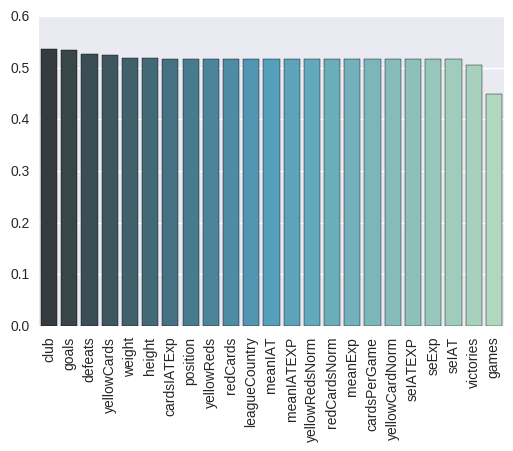

In [52]:
# Plot graph
graph = sns.barplot(sil_names, sil_values, palette='GnBu_d')
graph.set_xticklabels(labels=sil_names, rotation=90)
plt.show()

As we can see, if we remove the feature *club* from our dataset *data_player*, we achieve a better score than removing any other columns.

#### Loop and loop again
We perform the same algorithm now, by removing at each iteration the "best" candidate feature. We stop when there is only one remaining feature or when removing the "best" feature doesn't improve our model.

In [64]:
def KMeans_loop(new_data, silhouette=True):
    """
        By perfoming the KMeans algorithm, update the data by removing at each iteration
        the features giving the best score.
        Stop the iteration if there is only one feature left, or if removing a feature
        doesn't improve the score of the dataset.
        
        The score is compute either with the silhouette score, or by the "white/black" classification.
        
        INPUT:
            @new_data: The dataframe on which peforming the algorithm
            @silhouette: Boolean. If True, use the silhouette score. 
                                  If False, use the skin color accuracy.
                                  
        OUTPUT:
            @new_data: The updated dataframe, with columns removed
            This also prints its result.
    """
    
    
    # KMeans score for the ENTIRE dataset, with ALL features
    kmeans = KMeans(n_clusters=2).fit(X)
    if silhouette:
        all_features_score = sklearn.metrics.silhouette_score(X, kmeans.labels_)
    else:
        skin_sep = (kmeans.labels_ == y).sum() / len(y)
        all_features_score = max(skin_sep, 1-skin_sep)
    print("All features: ", all_features_score)


    # Helper variables for the loop
    col_to_remove = "nope"
    col_to_remove_score = -1
    score = all_features_score

    while True:
        # Remove once all columns
        for col in new_data.columns:

            # Remove the column
            data_without_col = new_data.drop(col, axis=1)

            # Use KMeans algorithm with 2 clusters
            kmeans = KMeans(n_clusters=2).fit(data_without_col)

            # Compute the score
            if silhouette:
                score_column = sklearn.metrics.silhouette_score(data_without_col, kmeans.labels_)
            else:
                skin_sep = (kmeans.labels_ == data_player.isBlack).sum() / len(y)
                score_column = max(skin_sep, 1-skin_sep)
                
                
            # Update the best column to remove
            if score_column > col_to_remove_score:
                col_to_remove = col
                col_to_remove_score = score_column


        # If removing a column doesn't improve the score, quit.
        if col_to_remove_score <= score:
            break


        else:
            # Update the data and the best score
            new_data = new_data.drop(col_to_remove, axis=1)
            score = col_to_remove_score
            print("Feature", col_to_remove, "removed (", score, ")")

            # Check if it is the last feature of the data
            if len(new_data.columns) == 1:
                break


    # Print results
    print("Remaining features:", list(new_data.columns))
    print("Accu", score)
    
    return new_data

In [65]:
new_data = KMeans_loop(X, silhouette=True)

All features:  0.517197990531
Feature club removed ( 0.535815839315 )
Feature goals removed ( 0.554841884337 )
Feature defeats removed ( 0.567893218976 )
Feature yellowCards removed ( 0.578714071707 )
Feature games removed ( 0.606469350727 )
Feature weight removed ( 0.6154260811 )
Feature height removed ( 0.625641630133 )
Feature position removed ( 0.628798366411 )
Feature yellowReds removed ( 0.62939343257 )
Feature redCards removed ( 0.629967885306 )
Feature leagueCountry removed ( 0.630486589384 )
Feature cardsIATExp removed ( 0.630497477079 )
Feature redCardsNorm removed ( 0.630505598954 )
Feature yellowRedsNorm removed ( 0.630513459661 )
Feature meanIAT removed ( 0.630521177784 )
Feature yellowCardNorm removed ( 0.630527965478 )
Feature meanIATEXP removed ( 0.630534690826 )
Feature meanExp removed ( 0.630541150813 )
Feature victories removed ( 0.635444238692 )
Feature cardsPerGame removed ( 0.800283023117 )
Feature seExp removed ( 0.801109910077 )
Feature seIATEXP removed ( 0.8116

We obtain the best silhouete score by removing all features, except the *seIAT* one. Remember that the *seIAT* is the mean of the *seIAT* score for each referee a given player has encounter.

But for use, keep only one features doesn't make a lot of sens, but...

#### Accuracy with best silhouette score
Now that we compute the best classification for two clusters using the best silhouette score, we want to assert how close this classification is from the "white/black" classification from our data.

In [66]:
# Compute KMeans
kmeans = KMeans(n_clusters=2).fit(new_data)

# Compare the two labels prediction with the skin color of the player
skin_sep = (kmeans.labels_ == data_player.isBlack).sum() / len(y)
skin_separation_accuracy = max(skin_sep, 1-skin_sep)

# Print the relation between the classification given by KMeans with silhouette and the white/black classfication
print(skin_separation_accuracy)

0.848870056497


As we can see, by only keeping the *seIAT* feature, we classify, based on the skin color, almost 85% of the player. It is a very good result, showing that the *seIAT* feature makes a lot of sens!

#### Skin cluster accuracy at each loop
Now, we will perform the same algorithm as before, but instead of removing the features based on the silhouette score, we will remove the features based on the accuracy of the cluster in comparison to the white/black cluster

In [68]:
new_data = KMeans_loop(X, silhouette=False)

All features:  0.614406779661
Feature games removed ( 0.630649717514 )
Feature defeats removed ( 0.667372881356 )
Feature victories removed ( 0.781779661017 )
Feature yellowCards removed ( 0.786016949153 )
Remaining features: ['redCards', 'height', 'seIAT', 'weight', 'meanExp', 'seExp', 'club', 'leagueCountry', 'meanIAT', 'yellowReds', 'goals', 'position', 'meanIATEXP', 'seIATEXP', 'cardsPerGame', 'yellowCardNorm', 'yellowRedsNorm', 'redCardsNorm', 'cardsIATExp']
Accu 0.786016949153


By removing the features based on the accuracy of the classifier (compare to the white/black classification), we achieve 78.6% of precision. This score is lower that the one obtain by the silhouette score, which only keep the *seIAT* feature !